# Point-by-point refinement notebook  
__Written by Haixing Fang, Jon Wright and James Ball__  
__Date: 21/02/2025__

This notebook will try to perform a point-by-point strain refinement of your pbp index results.  
As with the pbp index, the results of this process are multi-valued.  
You can run 4_visualise to convert the refinement results to an accurate single-valued map.  

### NOTE: It is highly recommended to run this notebook on a Jupyter server with many cores and a lot of RAM.  
The compute_origins() function in particular runs locally and can be compute-intensive for large datasets.  
If this is a big scan (e.g 100 million + 2D peaks), you should definitely refine on the cluster rather than locally.

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [2]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [3]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_path = 'si_cube_test/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5'

# which phase to refine
phase_str = 'Si'

# the minimum number of peaks you want a pixel to have to be counted
min_unique = 20

# threshold for whole-sample mask binarisation
manual_threshold = None

# refinement parameters
y0 = 0.0
hkl_tol_origins = 0.05
hkl_tol_refine = 0.1
hkl_tol_refine_merged = 0.05
ds_tol = 0.006
ifrac = 6e-3
rings_to_refine = None  # can be a list of rings
set_mask_from_input = False  # do we mask just from the min_unique value?
use_cluster = False

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [4]:
# Parameters
phase_str = "Au"
min_unique = 10
manual_threshold = None
y0 = -16.0
hkl_tol_origins = 0.05
hkl_tol_refine = 0.1
hkl_tol_refine_merged = 0.05
ds_tol = 0.004
ifrac = 0.007
rings_to_refine = None
set_mask_from_input = True
use_cluster = False
PYTHONPATH = "../"
dset_path = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/pbp_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_dataset.h5"


In [5]:
import numpy as np
from matplotlib import pyplot as plt

from ImageD11.grain import grain
from ImageD11 import unitcell
import ImageD11.sinograms.dataset
from ImageD11.sinograms.point_by_point import PBPMap, PBPRefine
from ImageD11.sinograms.tensor_map import TensorMap
from ImageD11.nbGui import nb_utils as utils

%matplotlib ipympl

# Load data
## Dataset

In [6]:
ds = ImageD11.sinograms.dataset.load(dset_path)
print(ds)

dataroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/RAW_DATA"
analysisroot = "/data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/pbp_route"
sample = "FeAu_0p5_tR_nscope"
dset = "top_200um"
shape = ( 275, 1448)
# scans 275 from 1.1 to 275.1


## Phases
If the parameter file was a json, we can access the unit cells via `ds.phases.unitcells`

In [7]:
# load phases from parameter file

ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Au': Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225,
 'Fe': Fe | [ 2.8694  2.8694  2.8694 90.     90.     90.    ] | 229,
 'CeO2': CeO2 | [ 5.41143  5.41143  5.41143 90.      90.      90.     ] | F}

In [8]:
ref_ucell = ds.phases.unitcells[phase_str]
print(ref_ucell)

Au | [ 4.005  4.005  4.005 90.    90.    90.   ] | 225


## Point-by-point map

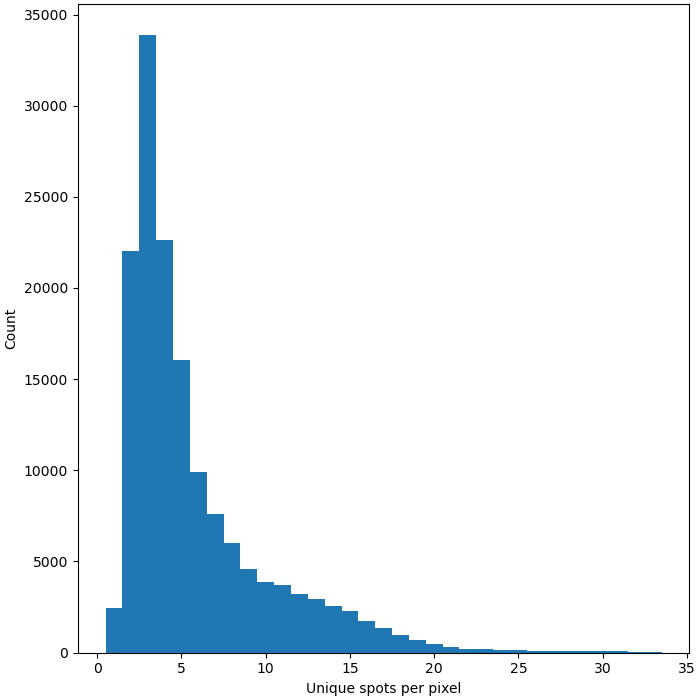

In [9]:
pmap = PBPMap(ds.pbpfile.replace('.txt', f'_{phase_str}.txt'))
pmap.plot_nuniq_hist()

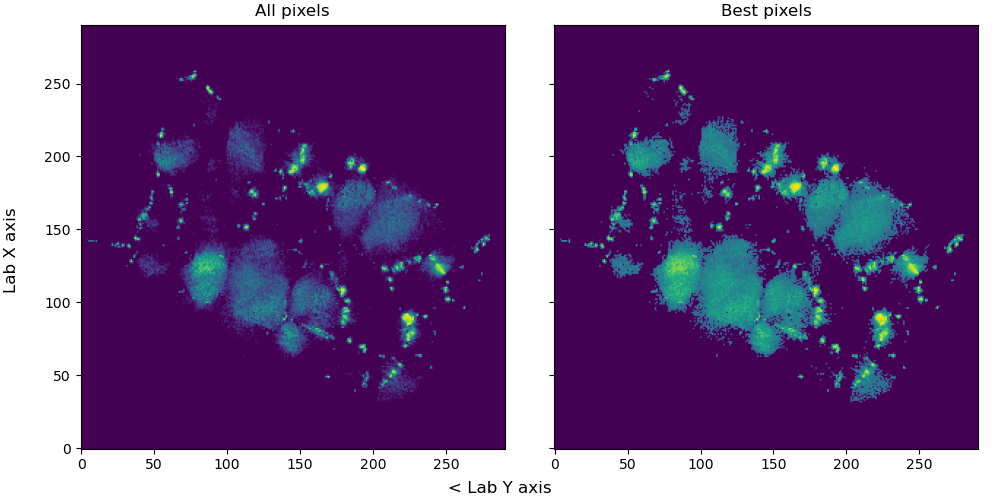

In [10]:
# choose the minimum number of peaks you want a pixel to have to be counted
pmap.choose_best(min_unique)
pmap.plot_best(min_unique)

## Peaks

In [11]:
cf_2d = ds.get_cf_2d()
ds.update_colfile_pars(cf_2d)
print(f"Read {cf_2d.nrows} 2D peaks")

Loading existing colfile from /data/id11/inhouse2/test_data_3DXRD/S3DXRD/FeAu/PROCESSED_DATA/20250221_JADB/pbp_route/FeAu_0p5_tR_nscope/FeAu_0p5_tR_nscope_top_200um/FeAu_0p5_tR_nscope_top_200um_peaks_2d.h5
Reading your columnfile in hdf format


Read 19112858 2D peaks


# Refinement

In [12]:
# set up a refinement manager object
refine = PBPRefine(dset=ds, y0=y0, hkl_tol_origins=hkl_tol_origins, hkl_tol_refine=hkl_tol_refine, hkl_tol_refine_merged=hkl_tol_refine_merged, ds_tol=ds_tol, ifrac=ifrac, phase_name=phase_str, forref=rings_to_refine)
# change the default paths of the refinement manager to append the phase name
refine.own_filename = os.path.splitext(refine.own_filename)[0] + f'_{phase_str}.h5'
refine.icolf_filename = os.path.splitext(refine.icolf_filename)[0] + f'_{phase_str}.h5'
refine.pbpmap_filename = os.path.splitext(refine.pbpmap_filename)[0] + f'_{phase_str}.h5'
refine.refinedmap_filename = os.path.splitext(refine.refinedmap_filename)[0] + f'_{phase_str}.h5'

In [13]:
# tell it which point-by-point map we are refining
refine.setmap(pmap)

# or load from disk:
# refine.loadmap()

In [14]:
# choose 2D peaks to refine with
refine.setpeaks(cf_2d)

# or load from disk:
# refine.loadpeaks()

I will delete an existing refined peaks H5 file if I find it on disk!
Waiting 10 seconds for you to interrupt this if you are unhappy


Continuing
To disable this prompt, set prompt_del=False when calling setpeaks()


0 0.4325 (1, 1, 1) 8 16905 used, sum_intensity> 193.291


1 0.4994 (0, 2, 0) 6 12776 used, sum_intensity> 168.889
2 0.7062 (2, 0, 2) 12 23076 used, sum_intensity> 64.519


3 0.8281 (1, 3, 1) 24 38122 used, sum_intensity> 41.286
4 0.8649 (2, 2, 2) 8 12166 used, sum_intensity> 38.647


5 0.9988 (4, 0, 0) 6 7974 used, sum_intensity> 25.851
6 1.0884 (1, 3, 3) 24 23237 used, sum_intensity> 20.265


7 1.1166 (2, 4, 0) 24 17207 used, sum_intensity> 26.425
8 1.2232 (2, 2, 4) 24 10250 used, sum_intensity> 36.568


9 1.2974 (5, 1, 1) 32 17349 used, sum_intensity> 93.044
10 1.4124 (0, 4, 4) 12 9684 used, sum_intensity> 11.69


11 1.4772 (1, 3, 5) 48 315736 used, sum_intensity> 232.729
12 1.4981 (0, 0, 6) 30 17886 used, sum_intensity> 5.306


13 1.5792 (6, 0, 2) 24 9856 used, sum_intensity> 9.415000000000001
14 1.6373 (5, 3, 3) 24 168322 used, sum_intensity> 194.03300000000002


15 1.6562 (2, 6, 2) 24 7695 used, sum_intensity> 9.513


16 1.7299 (4, 4, 4) 8 4222 used, sum_intensity> 6.867


17 1.7831 (5, 5, 1) 48 31832 used, sum_intensity> 68.012


18 1.8005 (0, 6, 4) 24 2856 used, sum_intensity> 2.5340000000000003
19 1.8685 (4, 2, 6) 48 2765 used, sum_intensity> 2.6670000000000003


20 1.9179 (5, 3, 5) 72 5050 used, sum_intensity> 3.318
21 1.9975 (0, 0, 8) 6 454 used, sum_intensity> 1.05


22 2.0438 (3, 7, 3) 24 767 used, sum_intensity> 2.331
23 2.0590 (4, 4, 6) 48 630 used, sum_intensity> 1.176


24 2.1187 (6, 6, 0) 36 428 used, sum_intensity> 3.3040000000000003
25 2.1624 (5, 5, 5) 56 25 used, sum_intensity> 0.147


26 2.1767 (6, 2, 6) 24 160 used, sum_intensity> 0.707


Using for refinement: 757430 npks, forref 724 range(0, 27)


(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='$d^{*}~(\\AA^{-1})$', ylabel='sum intensity'>,
        <Axes: xlabel='$\\omega~(\\degree)$', ylabel='dty'>], dtype=object))

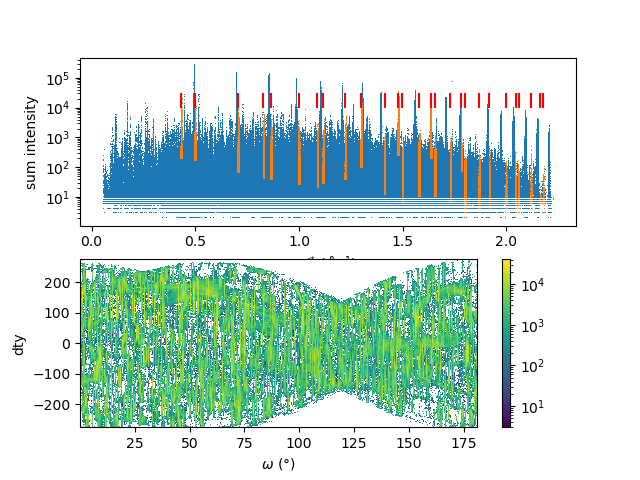

In [15]:
# plot the peaks you selected
refine.iplot()

In [16]:
# generate a single-valued map to refine on
refine.setsingle(refine.pbpmap, minpeaks=min_unique)

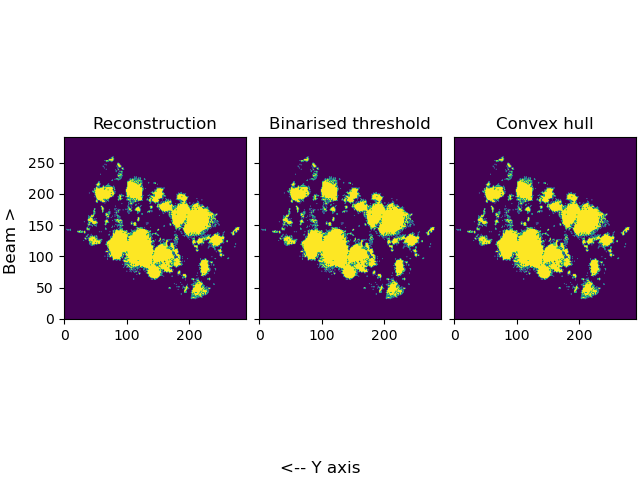

In [17]:
# set whole-sample mask to choose where to refine
# if use_singlemap is true, we will generate a mask simply based on where self.singlemap > min_unique
refine.setmask(manual_threshold=manual_threshold, doplot=True, use_singlemap=set_mask_from_input)

# Compute peak diffraction origins

In [18]:
# compute diffraction origins - these will be added as a column to refine.icolf
# will then save the new column to disk to avoid re-computation
refine.get_origins()

Getting gvecs...
Running test function twice for the first 10000 peaks to guess speed...
This is because we get speed advantages with peaks on consecutive frames
First time to trigger NJIT
Now we time
I estimate roughly 0.3810144209986003 seconds for all peaks in self.icolf
That's 0.00010583733916627785 hours
Lexsort...


Running numba computation on 39 threads, may take a while!


xpos_refined column added to self.icolf
Saving self.icolf to disk with new column


# Run refinement

In [19]:
# run the refinement
# if compute_origins took more than a couple of minutes to run, I suggest setting use_cluster=True below
# otherwise if you asked for lots of cores and RAM on this Jupyter instance, you can run it locally (use_cluster=False)
refine.run_refine(use_cluster=use_cluster, pythonpath=PYTHONPATH)

Launching Numba parallel refinement on 39 threads


Saving refined map to disk


# Export

In [20]:
# make sure refinement is saved to disk

refine.to_h5()

ds.save()

Saving icolf to disk


Saving input map to disk
Saving output map to disk
Saving myself to disk
